# Green_Team_Inference_Framework
## Utilizing ICEES, Ros, Gamma, and other services, to find meaningful connections.
<br>

![ros_asthma_graph_large](ros_asthma_graph_large.png)

## Figure 1. A graph, generated by Ros through calls to Gamma, ICEES, and other Translator services. Using information in the drug:disease ICEES-derived edges, a list of FDA-approved drugs will be ranked for efficacy. Later, ROBOKOP-derived edges will be used in finding the gene nodes impacted by chemical exposure.

In [1]:
import json
import pandas
import networkx
from pandas.io.json import json_normalize
from collections import defaultdict
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#The above allows for the import of local modules (ros.client) in this notebook
from ros.client import Client

In [2]:
workflow = '../../ros-t10r/translator/ros/workflows/green-cqs.ros'
libpath = [ '../../ros-t10r/translator/ros/workflows' ]
args = {
    "disease_name" : "asthma",
    "drug_name" : "Prednisone"
}
""" general. """
ros = Client (url="http://localhost:5002")
response = ros.run (workflow=workflow,
                    args = args,
                    library_path = libpath)

In [3]:
data = json.dumps(response.result) #this is a string
data_json = json.loads(data) #this is a list
icees_result_graph = data_json[0][0]['result_list'][0]['result_graph']
icees_node_list = icees_result_graph['node_list']
icees_edge_list = icees_result_graph['edge_list']

In [4]:
source_id_list = []
for x in icees_node_list:
    for key, value in x.items():
        if key == 'name':
            source_id_list.append(x['id'])

In [5]:
all_icees_edges_dict = defaultdict(dict)

for x in icees_edge_list:
    icees_edge_dict = defaultdict(dict)
    for key, value in x.items():
        if key == 'source_id' and value in source_id_list:
            icees_edge_dict = defaultdict(dict)
            icees_edge_data = x['edge_attributes']
            drug_name = icees_edge_data['feature_b']['feature_name']
            source_id = value             
            if all_icees_edges_dict[drug_name]:
                all_icees_edges_dict[drug_name]['source_id'].append(source_id)
            else:
                number_patients_in_cohort = icees_edge_data['total']
                patients_with_ED_under_2_total_cohort = icees_edge_data['columns'][0]['frequency']
                patients_with_ED_over_2_total_cohort = icees_edge_data['columns'][1]['frequency']
                percentage_patients_with_ED_under_2_total_cohort = 100*patients_with_ED_under_2_total_cohort/number_patients_in_cohort
                number_patients_this_drug_EDVisits_under_2 = icees_edge_data['feature_matrix'][1][0]['frequency']
                number_patients_this_drug_EDVisits_over_2 = icees_edge_data['feature_matrix'][1][1]['frequency']
                number_patients_admin_this_drug = icees_edge_data['rows'][1]['frequency']
                number_patients_other_drugs_EDVisits_less_than_2 = icees_edge_data['feature_matrix'][0][0]['frequency']
                number_patients_other_drugs_EDVisits_over_2 = icees_edge_data['feature_matrix'][0][1]['frequency']
                number_patients_admin_other_drugs = icees_edge_data['rows'][0]['frequency']
                
                percentage_of_cohort_taking_this_drug = 100*number_patients_admin_this_drug / number_patients_in_cohort
                icees_edge_dict['Percentage of Cohort administered this Drug'] = percentage_of_cohort_taking_this_drug
                
                Prob_A_given_B = 100*number_patients_this_drug_EDVisits_under_2/number_patients_admin_this_drug
                icees_edge_dict['Percentage of Patients taking this Drug who have EDVisits < 2'] = Prob_A_given_B
                Prob_B_given_A = 100*(number_patients_this_drug_EDVisits_under_2/patients_with_ED_under_2_total_cohort)

                responsiveness_to_treatment = round(Prob_A_given_B - percentage_patients_with_ED_under_2_total_cohort, 2)
                icees_edge_dict['Responsiveness to Treatment given Administration of this Drug'] = responsiveness_to_treatment
                
                weighted_responsiveness_to_treatment = responsiveness_to_treatment*percentage_of_cohort_taking_this_drug
                icees_edge_dict['Weighted Responsiveness'] = weighted_responsiveness_to_treatment / 100

                all_icees_edges_dict[drug_name]=dict(icees_edge_dict)
                all_icees_edges_dict[drug_name]['source_id'] = []
                all_icees_edges_dict[drug_name]['source_id'].append(source_id) 

# CQ4 Goal: Ranked list of FDA-approved medications that are effective in patients with asthma and high levels of exposure to airborne pollutants

## COHORT:45 --> size: 21492, features: AvgDailyPM2.5Exposure > 2

In [6]:
all_icees_edges_dict_df = pandas.DataFrame(all_icees_edges_dict)
efficacy_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('Percentage of Patients taking this Drug who have EDVisits < 2', ascending=False).T
efficacy_sorted_icees_edges_dict_df.round(2)

,Mometasone,Cetirizine,Budesonide,Albuterol,Prednisone,Diphenhydramine,Salmeterol
Percentage of Cohort administered this Drug,1.56803,5.25312,4.59241,28.8759,10.483,13.3864,0.204727
Percentage of Patients taking this Drug who have EDVisits < 2,91.3947,87.2453,87.0314,82.1624,75.4993,75.113,59.0909
Responsiveness to Treatment given Administration of this Drug,8.1,3.95,3.74,-1.13,-7.8,-8.18,-24.21
Weighted Responsiveness,0.12701,0.207498,0.171756,-0.326297,-0.817672,-1.09501,-0.0495645
source_id,[PUBCHEM:441335],"[MESH:D017332, PUBCHEM:2678]","[MESH:D019819, PUBCHEM:5281004]","[MESH:D000420, PUBCHEM:2083]","[MESH:D011241, PUBCHEM:5865]","[MESH:D004155, PUBCHEM:3100]",[PUBCHEM:5152]


## Percentage of Patients taking this Drug who have EDVisits < 2 =
### (# patients administered drug AND with EDVisits < 2) / (# patients administered drug)
### ***

## Responsiveness to Treatment given Administration of this Drug = 
### (% patients administered drug AND with EDVisits< 2) - (% patients cohort with EDVisits<2)

### ***

## Weighted Responsiveness = 

### (Responsiveness * (% of patients administered this drug)) / 100

### ***

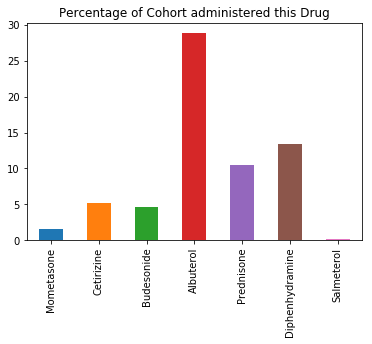

In [12]:
plot0 = efficacy_sorted_icees_edges_dict_df.iloc[0].plot(kind='bar',title = 'Percentage of Cohort administered this Drug')

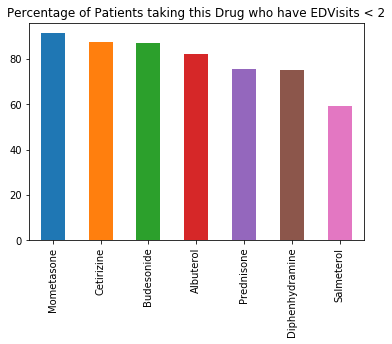

In [8]:
plot2 = efficacy_sorted_icees_edges_dict_df.iloc[1].plot(kind='bar',title = 'Percentage of Patients taking this Drug who have EDVisits < 2')

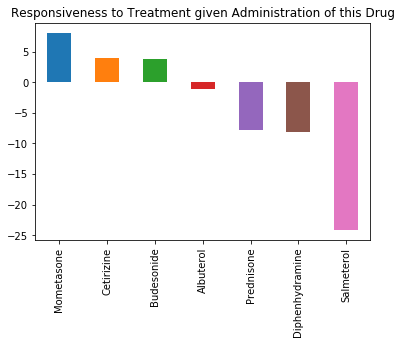

In [9]:
plot3 = efficacy_sorted_icees_edges_dict_df.iloc[2].plot(kind='bar',title = 'Responsiveness to Treatment given Administration of this Drug')

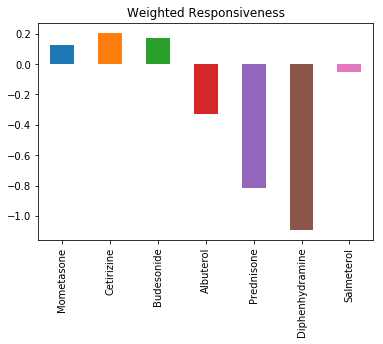

In [10]:
plot3 = efficacy_sorted_icees_edges_dict_df.iloc[3].plot(kind='bar',title = 'Weighted Responsiveness')

In [14]:
weighted_responsiveness_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('Weighted Responsiveness', ascending=False).T
thing = list(weighted_responsiveness_sorted_icees_edges_dict_df)
thing

['Cetirizine',
 'Budesonide',
 'Mometasone',
 'Salmeterol',
 'Albuterol',
 'Prednisone',
 'Diphenhydramine']

# CQ4 OUTPUT: 'Cetirizine', 'Budesonide', 'Mometasone' are the three most effective FDA-approved medications in patients with asthma and high levels of exposure of airborne pollutants (AvgDailyPM2.5Exposure > 2), in terms of weighted responsiveness to treatment.

<br> 
# CQ5 Goal:  Ranked lists of the protein (gene) targets and biological pathways of FDA-approved medications that are effective in patients with asthma and high levels of exposure to airborne pollutants

![ros_asthma_graph_small](ros_asthma_graph_small.png)

## Figure 2.  Detail of the network graph from Figure 1, many nodes and edges removed. The remaining nodes and connections represent the drug-gene-disease pathways examined for CQ5.

<br> 
# Further Knowledge Goal: Vary AvgDailyPM2.5Exposure, examine effectiveness of drugs over that variation, look for influence of genes in that variation

# Next Implementation Goal: Convert this algorithm/code to a CLI and/or GUI tool